In [6]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)

In [72]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, ax, weights = None):
    K = int(mus.shape[0])
    #K = 2
    if weights is None:
        weights = np.ones(K)/K
    
    for k in range(K):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=4.*np.sqrt(val[0]), height=4.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        #ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    return

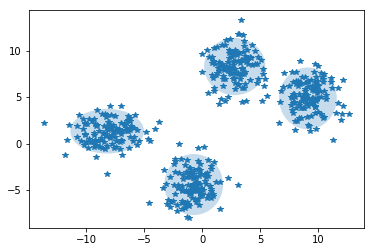

In [56]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K = 5
K_true = 4
N = 500
is_plot = True

mus_true = []
sigmas_true = []
samples = []
for k in range(K_true):
    mu = 5*np.random.normal(size=D)
    sigma = 3*np.diag(np.random.rand(D))
    sample = np.random.multivariate_normal(mu, cov = sigma, size = N/K_true)
    mus_true.append(mu)
    sigmas_true.append(sigma)
    samples.append(sample)
    
x = np.vstack(samples)
mus_true = np.array(mus_true)
sigmas_true = np.array(sigmas_true)

if is_plot:
    fig,ax = plt.subplots()
    plot_gaussian(mus_true,sigmas_true,ax)
    plt.plot(x[:,0],x[:,1],'*')

### Define the parameters 

In [9]:
#pi params
alpha0 = np.ones(K)*0.1
alpha = alpha0

#mu and sigma params
betha0 = 1
betha = np.ones(K)
mu0 = np.zeros(D)
W0 = np.eye(D)
v0 = D
mu = x[np.random.choice(len(x),size = K)]
W = [np.eye(D) for i in range(K)]
v = np.ones(K)*D

#

In [10]:
from scipy.special import digamma
from scipy.special import logsumexp

### expectation step

In [11]:
def log_normalize(x):
    return x - logsumexp(x)

In [12]:
def expectation(alpha, betha, mu, W, v, x):
    ln_ro = np.zeros([N,K])
    ro = np.zeros([N,K])
    
    print 'Calculating ro'
    tic = time.time()
    for k in range(K):
        E_s = D*np.log(2) + np.log(np.linalg.det(W[k])) + np.sum([digamma((v[k] + 1 - i)/2.) for i in range(D)])
        E_pi = digamma(alpha[k]) - digamma(np.sum(alpha))
        E_2 = D*np.log(2*np.pi)
        for n in range(N):
            E_ms = D/betha[k] + v[k]*np.dot(x[n] - mu[k], np.dot(W[k], x[n] - mu[k]))
            ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms
            
    for n in range(N):        
        ln_ro[n,:] = log_normalize(ln_ro[n,:])
        ro[n,:] = np.exp(ln_ro[n,:])
    toc = time.time()
    print toc-tic

    print 'Calculating Nk'
    tic = time.time()
    Nks = np.array([np.sum(ro[:,k]) for k in range(K)])
    toc = time.time()
    print toc-tic
    

    print 'Calculating xk'
    xks = np.dot(ro.T, x)
    for k in range(K):
        xks[k,:] /= Nks[k]
    toc = time.time()
    print toc-tic
    
    print 'Calculating Sk' 
    Sks = []
    for k in range(K):
        Sk = np.zeros([D,D])
        for n in range(N):
            Sk += ro[n,k]*np.outer(x[n]-xks[k], x[n]-xks[k])
        Sk /= Nks[k]
        Sks.append(Sk)
    
    toc = time.time()
    print toc-tic
    
    
    return ro, ln_ro, Nks, xks, Sks

def maximization(Nks, xks, Sks, ro):
    alpha = alpha0 + Nks
    betha = betha0 + Nks

    for k in range(K):
        mu[k] = (betha0*mu0 + Nks[k]*xks[k])/betha[k]
        Wk_inv = np.linalg.inv(W0) + Nks[k]*Sks[k] + np.outer(xks[k]-mu0, xks[k]-mu0)*betha0*Nks[k]/(betha0+Nks[k])
        W[k] = np.linalg.inv(Wk_inv)
        v[k] = v0 + Nks[k]
    
    return alpha, betha, mu, W, v


In [767]:
import time

for i in range(30):
    print 'Iteration ' + str(i)
    print 'Expectation'
    tic = time.time()
    ro, ln_ro, Nks, xks, Sks = expectation(alpha, betha, mu, W, v, x)
    toc = time.time()
    print toc-tic

    print 'Maximization'
    tic = time.time()
    alpha, betha, mu, W, v = maximization(Nks, xks, Sks, ro)
    toc = time.time()
    print toc-tic


Iteration 0
Expectation
Calculating ro
1.92328000069
Calculating Nk
0.000528812408447
Calculating xk
0.00169491767883
Calculating Sk
1.53369188309
3.45758199692
Maximization
0.00886702537537
Iteration 1
Expectation
Calculating ro
1.92752814293
Calculating Nk
0.000401020050049
Calculating xk
0.00179195404053
Calculating Sk
1.57078289986
3.49878096581
Maximization
0.00358700752258
Iteration 2
Expectation
Calculating ro
1.93645715714
Calculating Nk
0.000393867492676
Calculating xk
0.00168395042419
Calculating Sk
1.57053685188
3.50750803947
Maximization
0.00387597084045
Iteration 3
Expectation
Calculating ro
1.95281505585
Calculating Nk
0.000488042831421
Calculating xk
0.0016930103302
Calculating Sk
1.62337803841
3.57688593864
Maximization
0.00223088264465
Iteration 4
Expectation
Calculating ro
1.94130301476
Calculating Nk
0.000243902206421
Calculating xk
0.00125885009766
Calculating Sk
1.56788086891
3.51033687592
Maximization
0.00916504859924
Iteration 5
Expectation
Calculating ro
1.99082

In [773]:
sigmas = [np.linalg.inv(v[k]*W[k]) for k in range(K)]
pis = alpha/np.sum(alpha)

In [775]:
print pis

[0.5    0.0005 0.0202 0.1482 0.3312]


In [776]:
if is_plot:
    fig,ax = plt.subplots()
    plt.plot(x[:,0],x[:,1],'r*',zorder=1)
    plot_gaussian(mu,sigmas,ax, pis)

In [777]:
for k in range(K):
    if pis[k] > 0.1: 
        print pis[k]
        print mu[k]

0.49999625004687437
[-8.6683  2.7609 -6.7305 -0.9055  3.5907  0.0278  1.7871  4.417  -2.8146
 -4.6792  2.6002  1.8998  0.4251  1.5035  0.113  -5.033  -1.7115 -1.4696
 -2.5152 -2.1759  2.6834 -0.9074 -1.1848 -2.1309 -4.404 ]
0.14822036546804138
[ -1.8696   9.6085  -5.5255   4.953   -0.6253   0.5476  -6.9743  -1.4933
  -5.8154  -1.5329   4.0315  -3.0967 -11.5813  -5.1405   9.6936  -4.4168
  11.7063   5.2548  -5.7146   6.6657   0.0632  -0.2553  -4.1933   4.6598
  -3.2653]
0.33116025510115393
[ -2.3487   9.1882  -5.6359   4.9018  -0.583    0.9416  -6.9506  -1.6298
  -6.4834  -1.6711   3.7991  -2.9316 -11.5929  -5.0587   9.8182  -4.4168
  11.694    5.2587  -5.7958   7.5007   0.0516  -0.2421  -4.3261   4.6629
  -3.0183]


In [778]:
print mus_true

[[ -8.6586   2.7586  -6.7332  -0.9139   3.5962   0.0184   1.7815   4.4221
   -2.8126  -4.6787   2.5914   1.8995   0.4284   1.5045   0.1138  -5.0166
   -1.6954  -1.4696  -2.5163  -2.1988   2.6922  -0.9087  -1.184   -2.1253
   -4.3999]
 [ -2.2008   9.3413  -5.605    4.9371  -0.6107   0.7984  -6.9538  -1.5919
   -6.2386  -1.6245   3.8638  -3.0214 -11.5973  -5.0893   9.7896  -4.4131
   11.699    5.2599  -5.7691   7.2315   0.0535  -0.2484  -4.2894   4.6499
   -3.0538]]


In [780]:
from sklearn.mixture import BayesianGaussianMixture

BGMM = BayesianGaussianMixture(n_components=10)

BGMM.fit(x)

### Try on Data 

In [4]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')['sarcos_inv']
data_test = loadmat('data/sarcos_inv_test.mat')['sarcos_inv_test']

In [5]:
data_train.shape

(44484, 28)

In [13]:
x = data_train

In [21]:
D = x.shape[1]
K = 100
N = x.shape[0]

### Define the parameters 

In [22]:
#pi params
alpha0 = np.ones(K)*0.1
alpha = alpha0

#mu and sigma params
betha0 = 1
betha = np.ones(K)
mu0 = np.zeros(D)
W0 = np.eye(D)
v0 = D
mu = x[np.random.choice(len(x),size = K)]
W = [np.eye(D) for i in range(K)]
v = np.ones(K)*D


In [23]:
import time

for i in range(30):
    print 'Iteration ' + str(i)
    print 'Expectation'
    tic = time.time()
    ro, ln_ro, Nks, xks, Sks = expectation(alpha, betha, mu, W, v, x)
    toc = time.time()
    print toc-tic

    print 'Maximization'
    tic = time.time()
    alpha, betha, mu, W, v = maximization(Nks, xks, Sks, ro)
    toc = time.time()
    print toc-tic


Iteration 0
Expectation
Calculating ro
22.3091042042
Calculating Nk
0.0112209320068
Calculating xk
0.0177338123322
Calculating Sk
35.3849649429
57.6943640709
Maximization
0.0233180522919
Iteration 1
Expectation
Calculating ro
22.4431409836
Calculating Nk
0.0111629962921
Calculating xk
0.0232119560242
Calculating Sk
35.9816551208
58.4266340733
Maximization
0.0236270427704
Iteration 2
Expectation
Calculating ro
22.2615408897
Calculating Nk
0.0108561515808
Calculating xk
0.024453163147
Calculating Sk
35.9853551388
58.2485601902
Maximization
0.0239589214325
Iteration 3
Expectation
Calculating ro
22.2901940346
Calculating Nk
0.0119841098785
Calculating xk
0.0258281230927
Calculating Sk
36.4268980026
58.7193419933
Maximization
0.0236909389496
Iteration 4
Expectation
Calculating ro
22.2955851555
Calculating Nk
0.0110509395599
Calculating xk
0.0257029533386
Calculating Sk
36.505628109
58.8030760288
Maximization
0.0238289833069
Iteration 5
Expectation
Calculating ro
23.4135909081
Calculating Nk

/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in divide


36.9290049076
59.46824193
Maximization
0.0226979255676
Iteration 18
Expectation
Calculating ro


/usr/local/lib/python2.7/dist-packages/numpy/linalg/linalg.py:2010: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/usr/local/lib/python2.7/dist-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


22.8671507835
Calculating Nk
0.0116400718689
Calculating xk
0.0173370838165
Calculating Sk
37.3882811069
60.2579860687
Maximization
0.0269229412079
Iteration 19
Expectation
Calculating ro
22.7007799149
Calculating Nk
0.0114879608154
Calculating xk
0.0170619487762
Calculating Sk
35.9251229763
58.6283090115
Maximization
0.0244090557098
Iteration 20
Expectation
Calculating ro
22.9572818279
Calculating Nk
0.0117518901825
Calculating xk
0.017550945282
Calculating Sk
35.9149768353
58.8745610714
Maximization
0.0217981338501
Iteration 21
Expectation
Calculating ro
22.7601799965
Calculating Nk
0.0119111537933
Calculating xk
0.017550945282
Calculating Sk
35.7258269787
58.4886090755
Maximization
0.0232570171356
Iteration 22
Expectation
Calculating ro
24.2818799019
Calculating Nk
0.0114371776581
Calculating xk
0.0170841217041
Calculating Sk
36.0788230896
60.3632478714
Maximization
0.022989988327
Iteration 23
Expectation
Calculating ro
22.6928040981
Calculating Nk
0.0127990245819
Calculating xk
0.0

### Define class for GMM and GMR

In [122]:
class GMM():
    def __init__(self, n_comp = 10, D = 1, K = 2, weight_concentration = 0.1):
        self.n_comp = n_comp
        self.D = D
        self.K = K

        #pi params
        self.alpha0 = np.ones(K)*weight_concentration
        self.alpha = np.copy(self.alpha0)

        #mu and sigma params
        self.betha0 = 1
        self.betha = np.ones(self.K)
        self.mu0 = np.zeros(self.D)
        self.W0 = np.eye(self.D)
        self.v0 = self.D
        #self.mu = x[np.random.choice(len(x),size = self.K)]
        self.W = [np.eye(self.D) for i in range(self.K)]
        self.v = np.ones(self.K)*self.D
        
    def fit(self,x, num_iter = 10):
        self.x = x
        self.N = self.x.shape[0]
        self.mu = self.x[np.random.choice(len(x),size = self.K)]

        for i in range(num_iter):
            print self.mu
            self.expectation()
            print self.mu
            print self.ro
            self.maximization()
            
        self.sigma = []
        for k in range(self.K):
            sigma = self.v[k]*self.W[k]
            self.sigma.append(sigma)

        self.weights = self.alpha/np.sum(self.alpha)
        
        print 'mus', self.mu
        print 'pis', self.weights
        
    def log_normalize(self,x):
        return x - logsumexp(x)

    def expectation(self):
        self.ln_ro = np.zeros([self.N,self.K])
        self.ro = np.zeros([self.N,self.K])

        print 'Calculating ro'
        tic = time.time()
        for k in range(self.K):
            E_s = self.D*np.log(2) + np.log(np.linalg.det(self.W[k])) + np.sum([digamma((self.v[k] + 1 - i)/2.) \
                                                                           for i in range(self.D)])
            E_pi = digamma(self.alpha[k]) - digamma(np.sum(self.alpha))
            E_2 = self.D*np.log(2*np.pi)
            for n in range(self.N):
                E_ms = self.D/self.betha[k] + self.v[k]*np.dot(self.x[n] - self.mu[k], np.dot(self.W[k], \
                                                                                self.x[n] - self.mu[k]))
                self.ln_ro[n,k] = E_pi + 0.5*E_s - 0.5*E_2 - 0.5*E_ms

        for n in range(self.N):        
            self.ln_ro[n,:] = log_normalize(self.ln_ro[n,:])
            self.ro[n,:] = np.exp(self.ln_ro[n,:])
        toc = time.time()
        print toc-tic


        self.Nks = np.array([np.sum(self.ro[:,k]) for k in range(self.K)])

        self.xks = np.dot(self.ro.T, self.x)
        for k in range(self.K):
            self.xks[k,:] /= self.Nks[k]


        print 'Calculating Sk' 
        self.Sks = []
        for k in range(self.K):
            Sk = np.zeros([self.D,self.D])
            for n in range(self.N):
                Sk += self.ro[n,k]*np.outer(self.x[n]-self.xks[k], self.x[n]-self.xks[k])
            Sk /= self.Nks[k]
            self.Sks.append(Sk)

        toc = time.time()
        print toc-tic
             
    def maximization(self):
        self.alpha = self.alpha0 + self.Nks
        self.betha = self.betha0 + self.Nks

        for k in range(self.K):
            self.mu[k] = (self.betha0*self.mu0 + self.Nks[k]*self.xks[k])/self.betha[k]
            Wk_inv = np.linalg.inv(self.W0) + self.Nks[k]*self.Sks[k] + np.outer(self.xks[k]-self.mu0, \
                                    self.xks[k]-self.mu0)*self.betha0*self.Nks[k]/(self.betha0+self.Nks[k])
            self.W[k] = np.linalg.inv(Wk_inv)
            self.v[k] = self.v0 + self.Nks[k]
            
    def plot(self):
        fig,ax = plt.subplots()
        plot_gaussian(self.mu, self.sigma, ax, self.weights )


In [129]:
gmm = GMM(D = 2, K = 10, weight_concentration=0.02)

In [130]:
gmm.fit(x)

[[-5.8515  1.7227]
 [ 1.7087  8.5664]
 [-8.3977  3.2251]
 [-3.7604  2.3721]
 [ 2.2061  5.0369]
 [-6.1961  2.8023]
 [ 1.8595  8.3558]
 [ 1.0425 -1.9584]
 [ 2.1635  8.0704]
 [-2.5073 -6.1635]]
Calculating ro
0.03360414505
Calculating Sk
0.0672280788422
[[-5.8515  1.7227]
 [ 1.7087  8.5664]
 [-8.3977  3.2251]
 [-3.7604  2.3721]
 [ 2.2061  5.0369]
 [-6.1961  2.8023]
 [ 1.8595  8.3558]
 [ 1.0425 -1.9584]
 [ 2.1635  8.0704]
 [-2.5073 -6.1635]]
[[0.0005 0.     0.9994 ... 0.     0.     0.    ]
 [0.4686 0.     0.0193 ... 0.     0.     0.    ]
 [0.5189 0.     0.4704 ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.0011 0.     ... 0.     0.9876 0.    ]]
[[-6.7934  0.5873]
 [ 2.2128  9.152 ]
 [-9.043   1.4379]
 [-2.8032  0.9169]
 [ 8.1335  4.6679]
 [-6.347   1.9642]
 [ 2.472   8.5458]
 [-0.2417 -3.08  ]
 [ 5.2481  7.773 ]
 [-1.2186 -5.3318]]
Calculating ro
0.0254130363464
Calculating Sk
0.0584669113159
[[-6.

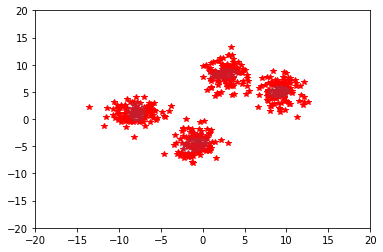

In [131]:
fig,ax = plt.subplots()
plot_gaussian(gmm.mu, gmm.sigma, ax, gmm.weights)
plt.plot(x[:,0], x[:,1], '*r',zorder=1)